In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
from sklearn.utils import resample
from keras.models import save_model
import keras
import dask
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Concatenate
from keras.applications.densenet import *
from numbers import Number
from keras.utils import to_categorical
import gc
import psutil
from cachetools import TTLCache
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
import tensorflow as tf
from keras.layers.advanced_activations import LeakyReLU






# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


        
input_filepath = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/"
train_image_filepath = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/"
# Any results you write to the current directory are saved as output.

Automatically created module for IPython interactive environment

Filename.........: ../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/ID_00019828f.dcm

Modality.........: CT
Image size.......: 512 x 512, 524288 bytes
Pixel spacing....: [0.488281, 0.488281]
Slice location...: (missing)


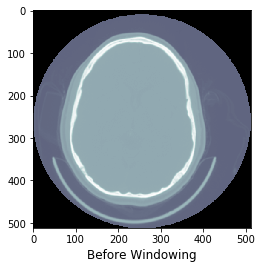

In [25]:
import matplotlib.pyplot as plt
import pydicom
from pydicom.data import get_testdata_files

print(__doc__)

filename = train_image_filepath + "ID_00019828f.dcm"
dataset = pydicom.dcmread(filename)

# Normal mode:
print()
print("Filename.........:", filename)
print()

print("Modality.........:", dataset.Modality)

if 'PixelData' in dataset:
    rows = int(dataset.Rows)
    cols = int(dataset.Columns)
    print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
        rows=rows, cols=cols, size=len(dataset.PixelData)))
    if 'PixelSpacing' in dataset:
        print("Pixel spacing....:", dataset.PixelSpacing)

# use .get() if not sure the item exists, and want a default value if missing
print("Slice location...:", dataset.get('SliceLocation', "(missing)"))

# plot the image using matplotlib
plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
plt.title('Before Windowing', y=-0.17)
plt.savefig('before-windowing.png')

plt.show()


In [26]:
dir(dataset)

['BitsAllocated',
 'BitsStored',
 'Columns',
 'HighBit',
 'ImageOrientationPatient',
 'ImagePositionPatient',
 'Modality',
 'PatientID',
 'PhotometricInterpretation',
 'PixelData',
 'PixelRepresentation',
 'PixelSpacing',
 'RescaleIntercept',
 'RescaleSlope',
 'Rows',
 'SOPInstanceUID',
 'SamplesPerPixel',
 'SeriesInstanceUID',
 'StudyID',
 'StudyInstanceUID',
 'WindowCenter',
 'WindowWidth',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_character_set',
 '_convert_pixel_data_using_handler',
 '_convert_pixel_data_without_handler',
 '_dataset_slice',
 '_do_pixel_data_conversion',
 '_pretty_str',
 '_sli

In [27]:
def brain_window(img):
    
    window_center =  img.WindowCenter if isinstance(img.WindowCenter, Number) else img.WindowCenter[0] 
    window_width = img.WindowWidth if isinstance(img.WindowWidth, Number) else img.WindowWidth[0] 
    slope, intercept  =  img.RescaleSlope, img.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = img.pixel_array
    img = img * dataset.RescaleSlope + intercept
    img[img < img_min] = img_min
    img[img > img_max] = img_max
    # Normalize
    img = (img - img_min) / (img_max - img_min)
    return img
    

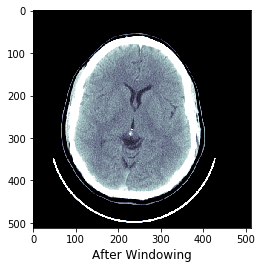

In [28]:
plt.imshow(brain_window(dataset), cmap=plt.cm.bone)
plt.title('After Windowing', y=-0.17)
plt.savefig('after-windowing.png')




In [29]:
def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = [a for a,b in zip(x,y) if b == yi ]
        class_xs.append((yi, elems))
        if min_elems == None or len(elems) < min_elems:
            min_elems = len(elems)

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            np.random.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.extend(x_)
        ys.extend(y_)

    print (xs[:10], ys[:10])
    return xs,ys

In [30]:
#########making y with all labels ################
#####multilabel###############
filename = train_image_filepath + "ID_00019828f.dcm"
file_dcm = pydicom.dcmread(filename)
print(file_dcm.pixel_array.shape)
def get_two_class_labels(csv_file_path, stratify_percentage=1):
    """returns a list of tuples where the first value is the file id and the second is the label
    [('ID_00019828f', 0)]
    """
    
    input_dataframe = pd.read_csv(csv_file_path)
    #filtered_input_dataframe = input_dataframe[input_dataframe['ID'].apply(lambda x : 'any' in x) ]
    files_with_ids = []

    
   # print(input_dataframe.columns.values)
    X = list(input_dataframe['ID'])
    y_dataframe = input_dataframe.drop(input_dataframe.columns[[0,1,7]], axis = 1)

    #print(y_dataframe.head)
  
    #y = [y_dataframe.columns.values.tolist()] + y_dataframe.values.tolist()
    y =  y_dataframe.values.tolist()
    #print (y[0])
    #print(len(X))
    #print(len(y))
    
    num_samples = int(stratify_percentage * len(X))
    print("Num Samples :", num_samples)
    
    for k,v in list(zip(X, y)) :
        files_with_ids.append( ("_".join(k.split('_')[:2]), v))
        
    return files_with_ids
        
    

def get_images(image_folder_root, image_label_list):
    """returns a list of tuples with ('ID',label,file) where file is the ndarray (with a readable shape )"""
    file_dcm=[]
    X = []
    y = []
    for file_name,label in image_label_list:
        try:
            current_file = pydicom.dcmread(image_folder_root + file_name + '.dcm')
            pixel_array = current_file.pixel_array
            if (pixel_array.shape != (512,512)):
                continue
            file_dcm.append((file_name,label,brain_window(current_file)))
            y.append(label)
            X.append(pydicom.dcmread(image_folder_root + file_name + '.dcm').pixel_array)
        except ValueError:
            continue
    return X,y

(512, 512)


In [31]:
#########making y with all labels ################
#####multilabel###############
def get_two_class_labels_fortest(csv_file_path_test, stratify_percentage=1):
    """returns a list of tuples where the first value is the file id and the second is the label
    [('ID_00019828f', 0)]
    """
    
    test_dataframe = pd.read_csv(csv_file_path_test)
    #filtered_input_dataframe = input_dataframe[input_dataframe['ID'].apply(lambda x : 'any' in x) ]
    files_with_ids_fortest = []
    
   # print(input_dataframe.columns.values)
    X_test = list(test_dataframe['ID'])
    
    print("Testing sample",X_test[0])
    
    y_test_df = test_dataframe.drop(test_dataframe.columns[[0,6]], axis = 1)
                  
    print("testing y samples")
    
  
    #y = [y_dataframe.columns.values.tolist()] + y_dataframe.values.tolist()
    y_test = y_test_df.values.tolist()
    #print (y[0])
    #print(len(X))
    #print(len(y))
    
    num_samples_train = int(stratify_percentage * len(X))
    num_samples_test = int(stratify_percentage * len(X_test))
    print("Num Samples in Training :", num_samples_train)
    print("Num Samples in Testing :", num_samples_test)
    
    for k,v in list(zip(X_test, y_test)) :
        files_with_ids_fortest.append( ("_".join(k.split('_')[:2]), v))
        
    return files_with_ids_fortest

def get_images(image_folder_root, image_label_list):
    """returns a list of tuples with ('ID',label,file) where file is the ndarray (with a readable shape )"""
    file_dcm=[]
    X_test = []
    y_test = []
    for file_name,label in image_label_list:
        try:
            current_file = pydicom.dcmread(image_folder_root + file_name + '.dcm')
            pixel_array = current_file.pixel_array
            if (pixel_array.shape != (512,512)):
                continue
            file_dcm.append((file_name,label,brain_window(current_file)))
            y_test.append(label)
            X_test.append(pydicom.dcmread(image_folder_root + file_name + '.dcm').pixel_array)
        except ValueError:
            continue
    return X_test,y_test

In [32]:
###using multilabel dataset
#csv_file_path = "../input/brain-ai/hem_positive_train_set.csv"
#csv_file_path = "../input/dsampled-positive-data/down_sampled_positive_data.csv"
#csv_file_path_test = "../input/positive-test/hem_positive_test_set.csv"
csv_file_path = "../input/brain-ai-equalsample/down_sampled_positive_data.csv"
csv_file_path_test = "../input/brain-ai/hem_positive_test_set.csv"
image_folder_root = train_image_filepath
files_with_ids = get_two_class_labels(csv_file_path,stratify_percentage=1)
X,y = [ x for x,y in files_with_ids], [y for x,y in files_with_ids]
print (len(files_with_ids))
print((y[0]))
print(X[0])

files_with_ids_fortest = get_two_class_labels_fortest(csv_file_path_test,stratify_percentage=1)
X_test,y_test = [ x_test for x_test,y_test in files_with_ids_fortest], [y_test for x_test,y_test in files_with_ids_fortest]
print (len(files_with_ids_fortest))
print((y_test))
print(X_test[0])


Num Samples : 12101
12101
[1, 0, 0, 0, 0]
ID_8375f06d2
Testing sample ID_e5b4b06d2
testing y samples
Num Samples in Training : 12101
Num Samples in Testing : 21587
21587
[[0, 0, 1, 1, 1], [0, 1, 0, 1, 0], [0, 1, 0, 0, 0], [0, 1, 0, 1, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 1, 1], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 0, 1], [0, 1, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 1, 0, 0, 0], [0, 0, 0, 1, 1], [0, 0, 0, 0, 1], [0, 1, 1, 1, 0], [0, 1, 0, 1, 1], [0, 0, 1, 0, 0], [0, 0, 0, 0, 1], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 1], [0, 0, 0, 1, 0], [0, 0, 0, 1, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 1, 1, 1, 0], [0, 1, 0, 0, 1], [0, 1, 0, 1, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 1, 1, 0, 0], [0, 0, 0, 0, 1], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0], [0, 1, 1, 0, 0], [0, 1, 0, 1, 1], [0, 1, 1, 1, 

In [33]:
class Model():
    
    
    def fit(self,X,y):
        raise NotImplemetedError()
    def predict(self, X):
        """Takes test data and returns the label probabilities """
        raise NotImplemetedError()

class Basic(Model):
    """intput dimension is the shape of the input"""
    def __init__(self, input_dimension, output_dimension):
        self.input_dimension = input_dimension
        self.output_dimension = output_dimension
        self.model = Sequential()
        self.model.add(Flatten())
        self.model.add(Dense(400,input_shape=(512,512)))
        self.model.add(LeakyReLU(alpha=0.3))
        self.model.add(Dense(200))
        self.model.add(LeakyReLU(alpha=0.3))
        self.model.add(Dense(50))
        self.model.add(LeakyReLU(alpha=0.3))
        self.model.add(Dense(25))
        self.model.add(LeakyReLU(alpha=0.3))
        self.model.add(Dense(10))
        self.model.add(LeakyReLU(alpha=0.3))
        self.model.add(Dense(5))
        self.model.add(Activation('sigmoid'))
        self.model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

 
        
    
    def fit(self, X,y):
        self.model.fit(x=X,y=y,epochs=1,batch_size=8)
    def predict(self, X):
        self.model.predict(X)
    def save(self,filename):
        self.model.save(filename)



In [34]:
############multiclass classifier, basic model, with 5 neurons in the output layer, sigmoid function and categorical cross-entropy#########
class Basic(Model):
    """intput dimension is the shape of the input"""
    def __init__(self, input_dimension, output_dimension):
        self.input_dimension = input_dimension
        self.output_dimension = output_dimension
        self.model = Sequential()
        self.model.add(Flatten())
        self.model.add(Dense(400,input_shape=(512,512)))
        self.model.add(LeakyReLU(alpha=0.3))
        self.model.add(Dense(200,input_shape=(512,512)))
        self.model.add(LeakyReLU(alpha=0.3))
        self.model.add(Dense(100,input_shape=(512,512)))
        self.model.add(LeakyReLU(alpha=0.3))
        #self.model.add(Activation('relu'))
        self.model.add(Dense(30))
        self.model.add(LeakyReLU(alpha=0.3))
        #self.model.add(Activation('relu'))
        self.model.add(Dense(15))
        self.model.add(LeakyReLU(alpha=0.3))
        #self.model.add(Activation('relu'))
        self.model.add(Dense(10))
        self.model.add(LeakyReLU(alpha=0.3))
        #self.model.add(Activation('relu'))
        self.model.add(Dense(5))
        self.model.add(Activation('sigmoid'))
        self.model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

 
        
    
    def fit(self, X,y):
        self.model.fit(x=X,y=y,epochs=1,batch_size=8)
    def predict(self, X):
        pred = self.model.predict(X)
        return pred
        
    #y=to_categorical(y)

In [35]:
#Has an image loader for providing the image for a given id in the dataset 
#Written separately so that we can add any preprocessing steps here while the image is being loaded into memory
class DataLoader:
    def __init__(self,base_file_path, cache_size=500, ttl_seconds=20):
        self.base_file_path = base_file_path
        self.cache = TTLCache(maxsize=cache_size,ttl=ttl_seconds)
        
        
    ##will apply only brain windowing while loading the image for now. Need to change this to apply all windowing functions. 
    def load_image(self, image_id):
        if image_id in self.cache:
            return self.cache[image_id]
        
        else:
            current_file = pydicom.dcmread(image_folder_root + image_id + '.dcm')
            pixel_array = brain_window(current_file)
            self.cache[image_id] = pixel_array
            return pixel_array
    def trigger_expire(self):
        self.cache.expire()

In [36]:
class  ModelTrainer(object):
    
    def __init__(self, dataloader, training_batch_size=8, split_size = 400):
        
        self.dataloader = dataloader
        self.split_size = split_size
        
    
    """Takes X and y as the file name and labels and """    
    def fit(self, X,y,model, epochs=5, training_batch_size=8):
        splits = len(y) // self.split_size +1
        
        splitter = StratifiedKFold(n_splits=splits, random_state=None, shuffle=True)
        count = 1
        while epochs > 0:
            X,y = shuffle(X,y)
            print("Starting epoch ",count)
            ##TODO: add a better split and shuffle mechanism
            processed = 0
            while processed < len(y):
                batch_imgs = []
                batch_labels = []
            
                current_x = X[processed:min(processed+self.split_size,len(y))]
                current_y = y[processed:min(processed+self.split_size,len(y))]
                for img,label in zip(current_x,current_y):
                    image = self.dataloader.load_image(img)
                    ##Figure out how many images are getting ignored because of this assumption
                    ##check if all reshape operations can happen in the dataloader
                    if image.shape != (512,512):
                        continue
                    batch_imgs.append(image)
                    batch_labels.append(label)
                print("Length of images",len(batch_imgs))
                print("Using  batch with size", len(batch_imgs), len(batch_labels), "Processed ", processed, "Total ", len(y))
                model.fit(np.array(batch_imgs),np.array(batch_labels))
                #model.predict(np.array(batch_imgs),np.array(batch_labels))
                self.dataloader.trigger_expire()
                del batch_imgs
                del batch_labels
                
                gc.collect()
                processed +=self.split_size
            print("Ending epoch", count)
            #save_model(model.model,"epoch-model-four.hdf5")
            #model.save("basic-model-1-epochs.h5")
            #model.model.save_model(model,h5pyBasic-model-1-epoch)
            epochs-=1
            count+=1
        
                
        return model
    
    def predict(self, X_test,y_test,model,epochs=5, training_batch_size=8 ):
            
            splits = len(y) // self.split_size +1
            splitter = StratifiedKFold(n_splits=splits, random_state=None, shuffle=False)
            processed = 0
            while processed < len(y_test):
                batch_imgs_test = []
                batch_labels_test = []
            
                current_x_test = X_test[processed:min(processed+self.split_size,len(y_test))]
                current_y_test = y_test[processed:min(processed+self.split_size,len(y_test))]
                for img,label in zip(current_x_test,current_y_test):
                    image = self.dataloader.load_image(img)
                    ##Figure out how many images are getting ignored because of this assumption
                    ##check if all reshape operations can happen in the dataloader
                    if image.shape != (512,512):
                        continue
                    batch_imgs_test.append(image)
                    batch_labels_test.append(label)
                #print("Length of images",len(batch_imgs_test))
                #print("using  batch with size", len(batch_imgs_test), len(batch_labels_test), "Processed ", processed, "Total ", len(y_test))

                
                batch_imgs_test = np.array(batch_imgs_test)
               # print("Length of images",len(batch_imgs_test))
               # print("Shape before reshaping",batch_imgs_test.shape)
            
            #predict_input = batch_imgs_test.reshape(len(X_test),2)
            
            #batch_imgs_test = np.expand_dims(batch_imgs_test, axis=1)
            #batch_imgs_test = np.expand_dims(batch_imgs_test, axis=1)
            
                #print("shape of input to predict",batch_imgs_test.shape)
                preds = model.predict(batch_imgs_test)
                #print("the predicted y is of length : ", len(preds))
                #print("first sample prediciton is ", preds[0])
                ##classwise precision, recall 
                ##classwise precision, recall 
                acc_sum = 0
                true_pos = 0
                false_pos = 0
                true_neg = 0
                false_neg = 0
                
                class_true_pos = np.zeros([5,1])
                class_true_neg = np.zeros([5,1])
                class_false_pos = np.zeros([5,1])
                class_false_neg = np.zeros([5,1])
                
                class_recall = np.zeros([5,1])
                class_precision= np.zeros([5,1])
                
                
                for i in range(len(preds)):
                    for j in range(len(preds[0])):
                        if(preds[i][j])>=0.5:
                            preds[i][j] = 1
                        if(preds[i][j]) < 0.5 :
                            preds[i][j] = 0
                for a in range(len(preds)):
                    if(np.all(batch_labels_test[a] == preds[a])):
                        acc_sum = acc_sum +1;
                    for b in range(len(preds[a])):
                        if(batch_labels_test[a][b] == preds[a][b] and preds[a][b] == 1):
                           # acc_sum = acc_sum+1
                            class_true_pos[b] = class_true_pos[b]+1
                            true_pos = true_pos+1
                            
                        if(batch_labels_test[a][b] == preds[a][b] and preds[a][b] == 0):   
                            class_true_neg[b] = class_true_neg[b]+1
                            true_neg = true_neg+1
                            
                        if(batch_labels_test[a][b] < preds[a][b]):
                            class_false_pos[b] = class_false_pos[b]+1
                            false_pos = false_pos+1
                            
                        if(batch_labels_test[a][b] > preds[a][b]):
                            class_false_neg[b] = class_false_neg[b]+1
                            false_neg = false_neg+1
                            
                accuracy = (acc_sum/len(preds))*100
                recall =    (true_pos) / (true_pos + false_neg)
                precision =  (true_pos)/(true_pos + false_pos)
                
                for c in range(len(class_recall)):
                    class_recall[c] = (class_true_pos[c]) / (class_true_pos[c] + class_false_neg[c])
                    class_precision[c] = (class_true_pos[c]) / (class_true_pos[c] + class_false_pos[c])
                    
                print("Accuracy",accuracy)
                print("Recall",recall)
                print("Precision",precision)
                print("Class-wise precision\n", class_precision )
                print("Class-wise recall\n", class_recall)
                print("\n")
                
                self.dataloader.trigger_expire()
                del batch_imgs_test
                del batch_labels_test
                processed +=self.split_size
                        
            return(preds,accuracy,recall,precision, class_recall, class_precision)
                          

In [37]:
#####MULTILABEL RUN#######
dataloader = DataLoader(train_image_filepath)
model = Basic(5,5)
trainer = ModelTrainer(dataloader,split_size=700)
model = trainer.fit(X,y,model,epochs = 50)


Starting epoch  1
Length of images 700
Using  batch with size 700 700 Processed  0 Total  12101
Epoch 1/1
700/700 [==============================] - 5s 7ms/step - loss: 3.3055 - accuracy: 0.5751
Length of images 698
Using  batch with size 698 698 Processed  700 Total  12101
Epoch 1/1
698/698 [==============================] - 4s 6ms/step - loss: 0.7626 - accuracy: 0.6198
Length of images 700
Using  batch with size 700 700 Processed  1400 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.6988 - accuracy: 0.6283
Length of images 698
Using  batch with size 698 698 Processed  2100 Total  12101
Epoch 1/1
698/698 [==============================] - 4s 6ms/step - loss: 0.6996 - accuracy: 0.6332
Length of images 699
Using  batch with size 699 699 Processed  2800 Total  12101
Epoch 1/1
699/699 [==============================] - 4s 6ms/step - loss: 0.6779 - accuracy: 0.6283
Length of images 700
Using  batch with size 700 700 Processed  3500 Total  12101
Epoch

Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.6081 - accuracy: 0.6746
Length of images 700
Using  batch with size 700 700 Processed  7000 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.6198 - accuracy: 0.6580
Length of images 699
Using  batch with size 699 699 Processed  7700 Total  12101
Epoch 1/1
699/699 [==============================] - 4s 6ms/step - loss: 0.6725 - accuracy: 0.6529
Length of images 700
Using  batch with size 700 700 Processed  8400 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.6631 - accuracy: 0.6354
Length of images 700
Using  batch with size 700 700 Processed  9100 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.6278 - accuracy: 0.6571
Length of images 700
Using  batch with size 700 700 Processed  9800 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.6090 - accuracy: 0.6677
L

Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.5832 - accuracy: 0.6849
Length of images 699
Using  batch with size 699 699 Processed  700 Total  12101
Epoch 1/1
699/699 [==============================] - 4s 6ms/step - loss: 0.6111 - accuracy: 0.6764
Length of images 700
Using  batch with size 700 700 Processed  1400 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.6169 - accuracy: 0.6726
Length of images 700
Using  batch with size 700 700 Processed  2100 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.5848 - accuracy: 0.6826
Length of images 700
Using  batch with size 700 700 Processed  2800 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.5991 - accuracy: 0.6614
Length of images 700
Using  batch with size 700 700 Processed  3500 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.5732 - accuracy: 0.6849
Le

700/700 [==============================] - 4s 6ms/step - loss: 0.5703 - accuracy: 0.6834
Length of images 700
Using  batch with size 700 700 Processed  7000 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.5651 - accuracy: 0.6886
Length of images 700
Using  batch with size 700 700 Processed  7700 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.5659 - accuracy: 0.6931
Length of images 700
Using  batch with size 700 700 Processed  8400 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.6300 - accuracy: 0.6580
Length of images 698
Using  batch with size 698 698 Processed  9100 Total  12101
Epoch 1/1
698/698 [==============================] - 4s 6ms/step - loss: 0.6125 - accuracy: 0.6734
Length of images 700
Using  batch with size 700 700 Processed  9800 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.5650 - accuracy: 0.6917
Length of i

700/700 [==============================] - 4s 6ms/step - loss: 0.5210 - accuracy: 0.7183
Length of images 700
Using  batch with size 700 700 Processed  700 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.5225 - accuracy: 0.7211
Length of images 699
Using  batch with size 699 699 Processed  1400 Total  12101
Epoch 1/1
699/699 [==============================] - 4s 6ms/step - loss: 0.5223 - accuracy: 0.7247
Length of images 700
Using  batch with size 700 700 Processed  2100 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.5407 - accuracy: 0.7100
Length of images 700
Using  batch with size 700 700 Processed  2800 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.5526 - accuracy: 0.7117
Length of images 699
Using  batch with size 699 699 Processed  3500 Total  12101
Epoch 1/1
699/699 [==============================] - 4s 6ms/step - loss: 0.5699 - accuracy: 0.6930
Length of im

700/700 [==============================] - 4s 6ms/step - loss: 0.5015 - accuracy: 0.7309
Length of images 700
Using  batch with size 700 700 Processed  7000 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.5094 - accuracy: 0.7386
Length of images 699
Using  batch with size 699 699 Processed  7700 Total  12101
Epoch 1/1
699/699 [==============================] - 4s 6ms/step - loss: 0.4963 - accuracy: 0.7356
Length of images 700
Using  batch with size 700 700 Processed  8400 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.4943 - accuracy: 0.7443
Length of images 700
Using  batch with size 700 700 Processed  9100 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.5103 - accuracy: 0.7283
Length of images 699
Using  batch with size 699 699 Processed  9800 Total  12101
Epoch 1/1
699/699 [==============================] - 4s 6ms/step - loss: 0.5140 - accuracy: 0.7282
Length of i

Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.4807 - accuracy: 0.7351
Length of images 700
Using  batch with size 700 700 Processed  700 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.4714 - accuracy: 0.7509
Length of images 699
Using  batch with size 699 699 Processed  1400 Total  12101
Epoch 1/1
699/699 [==============================] - 4s 6ms/step - loss: 0.4740 - accuracy: 0.7542
Length of images 700
Using  batch with size 700 700 Processed  2100 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.4610 - accuracy: 0.7557
Length of images 700
Using  batch with size 700 700 Processed  2800 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.4798 - accuracy: 0.7377
Length of images 700
Using  batch with size 700 700 Processed  3500 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.4807 - accuracy: 0.7571
Le

700/700 [==============================] - 4s 6ms/step - loss: 0.4361 - accuracy: 0.7809
Length of images 700
Using  batch with size 700 700 Processed  7000 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 5ms/step - loss: 0.4260 - accuracy: 0.7754
Length of images 699
Using  batch with size 699 699 Processed  7700 Total  12101
Epoch 1/1
699/699 [==============================] - 4s 6ms/step - loss: 0.4414 - accuracy: 0.7720
Length of images 700
Using  batch with size 700 700 Processed  8400 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.4403 - accuracy: 0.7723
Length of images 700
Using  batch with size 700 700 Processed  9100 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 5ms/step - loss: 0.4353 - accuracy: 0.7763
Length of images 698
Using  batch with size 698 698 Processed  9800 Total  12101
Epoch 1/1
698/698 [==============================] - 4s 5ms/step - loss: 0.4348 - accuracy: 0.7819
Length of i

Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.3903 - accuracy: 0.8040
Length of images 700
Using  batch with size 700 700 Processed  700 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.3792 - accuracy: 0.8206
Length of images 700
Using  batch with size 700 700 Processed  1400 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.4147 - accuracy: 0.7897
Length of images 700
Using  batch with size 700 700 Processed  2100 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.4198 - accuracy: 0.7891
Length of images 700
Using  batch with size 700 700 Processed  2800 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.3895 - accuracy: 0.8129
Length of images 700
Using  batch with size 700 700 Processed  3500 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.4059 - accuracy: 0.7931
Le

700/700 [==============================] - 4s 6ms/step - loss: 0.3643 - accuracy: 0.8246
Length of images 699
Using  batch with size 699 699 Processed  7000 Total  12101
Epoch 1/1
699/699 [==============================] - 4s 6ms/step - loss: 0.3755 - accuracy: 0.8114
Length of images 699
Using  batch with size 699 699 Processed  7700 Total  12101
Epoch 1/1
699/699 [==============================] - 4s 6ms/step - loss: 0.3857 - accuracy: 0.8132
Length of images 700
Using  batch with size 700 700 Processed  8400 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.4250 - accuracy: 0.7837
Length of images 700
Using  batch with size 700 700 Processed  9100 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.3743 - accuracy: 0.8103
Length of images 700
Using  batch with size 700 700 Processed  9800 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.3878 - accuracy: 0.8109
Length of i

Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.3046 - accuracy: 0.8620
Length of images 700
Using  batch with size 700 700 Processed  700 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 5ms/step - loss: 0.3541 - accuracy: 0.8277
Length of images 699
Using  batch with size 699 699 Processed  1400 Total  12101
Epoch 1/1
699/699 [==============================] - 4s 6ms/step - loss: 0.3115 - accuracy: 0.8549
Length of images 699
Using  batch with size 699 699 Processed  2100 Total  12101
Epoch 1/1
699/699 [==============================] - 4s 6ms/step - loss: 0.3053 - accuracy: 0.8555
Length of images 700
Using  batch with size 700 700 Processed  2800 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.3299 - accuracy: 0.8411
Length of images 700
Using  batch with size 700 700 Processed  3500 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.3088 - accuracy: 0.8491
Le

700/700 [==============================] - 4s 6ms/step - loss: 0.3014 - accuracy: 0.8583
Length of images 698
Using  batch with size 698 698 Processed  7000 Total  12101
Epoch 1/1
698/698 [==============================] - 4s 6ms/step - loss: 0.2979 - accuracy: 0.8616
Length of images 700
Using  batch with size 700 700 Processed  7700 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.3076 - accuracy: 0.8571
Length of images 699
Using  batch with size 699 699 Processed  8400 Total  12101
Epoch 1/1
699/699 [==============================] - 4s 6ms/step - loss: 0.3157 - accuracy: 0.8601
Length of images 700
Using  batch with size 700 700 Processed  9100 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.3260 - accuracy: 0.8449
Length of images 700
Using  batch with size 700 700 Processed  9800 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.3062 - accuracy: 0.8626
Length of i

Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.2438 - accuracy: 0.8894
Length of images 700
Using  batch with size 700 700 Processed  700 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.2437 - accuracy: 0.8880
Length of images 700
Using  batch with size 700 700 Processed  1400 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.2444 - accuracy: 0.8917
Length of images 699
Using  batch with size 699 699 Processed  2100 Total  12101
Epoch 1/1
699/699 [==============================] - 4s 6ms/step - loss: 0.2781 - accuracy: 0.8681
Length of images 700
Using  batch with size 700 700 Processed  2800 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.2733 - accuracy: 0.8743
Length of images 699
Using  batch with size 699 699 Processed  3500 Total  12101
Epoch 1/1
699/699 [==============================] - 4s 6ms/step - loss: 0.2597 - accuracy: 0.8795
Le

699/699 [==============================] - 4s 5ms/step - loss: 0.2356 - accuracy: 0.8870
Length of images 700
Using  batch with size 700 700 Processed  7000 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.2406 - accuracy: 0.8966
Length of images 698
Using  batch with size 698 698 Processed  7700 Total  12101
Epoch 1/1
698/698 [==============================] - 4s 6ms/step - loss: 0.2149 - accuracy: 0.9089
Length of images 700
Using  batch with size 700 700 Processed  8400 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.2117 - accuracy: 0.9031
Length of images 700
Using  batch with size 700 700 Processed  9100 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.2548 - accuracy: 0.8894
Length of images 700
Using  batch with size 700 700 Processed  9800 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.2441 - accuracy: 0.8926
Length of i

Epoch 1/1
699/699 [==============================] - 4s 6ms/step - loss: 0.2006 - accuracy: 0.9113
Length of images 700
Using  batch with size 700 700 Processed  700 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.1836 - accuracy: 0.9249
Length of images 700
Using  batch with size 700 700 Processed  1400 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.2319 - accuracy: 0.9037
Length of images 699
Using  batch with size 699 699 Processed  2100 Total  12101
Epoch 1/1
699/699 [==============================] - 4s 5ms/step - loss: 0.2267 - accuracy: 0.8981
Length of images 700
Using  batch with size 700 700 Processed  2800 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.2438 - accuracy: 0.8940
Length of images 700
Using  batch with size 700 700 Processed  3500 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.2191 - accuracy: 0.9020
Le

700/700 [==============================] - 4s 6ms/step - loss: 0.2180 - accuracy: 0.9026
Length of images 700
Using  batch with size 700 700 Processed  7000 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.1867 - accuracy: 0.9220
Length of images 700
Using  batch with size 700 700 Processed  7700 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.2121 - accuracy: 0.9057
Length of images 699
Using  batch with size 699 699 Processed  8400 Total  12101
Epoch 1/1
699/699 [==============================] - 4s 6ms/step - loss: 0.2062 - accuracy: 0.9041
Length of images 700
Using  batch with size 700 700 Processed  9100 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.2204 - accuracy: 0.9017
Length of images 700
Using  batch with size 700 700 Processed  9800 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.2138 - accuracy: 0.9026
Length of i

Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.1583 - accuracy: 0.9346
Length of images 700
Using  batch with size 700 700 Processed  700 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.1620 - accuracy: 0.9337
Length of images 700
Using  batch with size 700 700 Processed  1400 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.1830 - accuracy: 0.9243
Length of images 700
Using  batch with size 700 700 Processed  2100 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.1530 - accuracy: 0.9369
Length of images 700
Using  batch with size 700 700 Processed  2800 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.1836 - accuracy: 0.9226
Length of images 700
Using  batch with size 700 700 Processed  3500 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.1711 - accuracy: 0.9309
Le

700/700 [==============================] - 4s 6ms/step - loss: 0.1580 - accuracy: 0.9311
Length of images 700
Using  batch with size 700 700 Processed  7000 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.1884 - accuracy: 0.9254
Length of images 700
Using  batch with size 700 700 Processed  7700 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 5ms/step - loss: 0.1429 - accuracy: 0.9471
Length of images 700
Using  batch with size 700 700 Processed  8400 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.1677 - accuracy: 0.9286
Length of images 700
Using  batch with size 700 700 Processed  9100 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.1561 - accuracy: 0.9311
Length of images 700
Using  batch with size 700 700 Processed  9800 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.1422 - accuracy: 0.9411
Length of i

Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.1765 - accuracy: 0.9317
Length of images 700
Using  batch with size 700 700 Processed  700 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 5ms/step - loss: 0.1251 - accuracy: 0.9494
Length of images 700
Using  batch with size 700 700 Processed  1400 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.1423 - accuracy: 0.9457
Length of images 700
Using  batch with size 700 700 Processed  2100 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.1307 - accuracy: 0.9483
Length of images 700
Using  batch with size 700 700 Processed  2800 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.1332 - accuracy: 0.9471
Length of images 700
Using  batch with size 700 700 Processed  3500 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.1393 - accuracy: 0.9429
Le

699/699 [==============================] - 4s 6ms/step - loss: 0.1271 - accuracy: 0.9479
Length of images 700
Using  batch with size 700 700 Processed  7000 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.1520 - accuracy: 0.9346
Length of images 700
Using  batch with size 700 700 Processed  7700 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.1295 - accuracy: 0.9497
Length of images 699
Using  batch with size 699 699 Processed  8400 Total  12101
Epoch 1/1
699/699 [==============================] - 4s 6ms/step - loss: 0.1462 - accuracy: 0.9425
Length of images 700
Using  batch with size 700 700 Processed  9100 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 6ms/step - loss: 0.1278 - accuracy: 0.9454
Length of images 700
Using  batch with size 700 700 Processed  9800 Total  12101
Epoch 1/1
700/700 [==============================] - 4s 5ms/step - loss: 0.1584 - accuracy: 0.9329
Length of i

In [ ]:
prediction , accuracy,recall,precision,class_recall, class_precision  = trainer.predict(X_test,y_test,model)

Accuracy 22.063037249283667
Recall 0.49480249480249483
Precision 0.46804326450344147
Class-wise precision
 [[0.30769231]
 [0.38647343]
 [0.53846154]
 [0.48314607]
 [0.56382979]]
Class-wise recall
 [[0.44444444]
 [0.7079646 ]
 [0.35195531]
 [0.37719298]
 [0.51125402]]


Accuracy 24.606580829756798
Recall 0.539795918367347
Precision 0.49485500467726845
Class-wise precision
 [[0.40740741]
 [0.42206235]
 [0.53020134]
 [0.45      ]
 [0.62681159]]
Class-wise recall
 [[0.44      ]
 [0.73029046]
 [0.46745562]
 [0.37974684]
 [0.56168831]]


Accuracy 23.57142857142857
Recall 0.5260416666666666
Precision 0.4851104707012488
Class-wise precision
 [[0.43478261]
 [0.41605839]
 [0.46923077]
 [0.495     ]
 [0.59205776]]
Class-wise recall
 [[0.4       ]
 [0.68674699]
 [0.42068966]
 [0.41949153]
 [0.53770492]]


Accuracy 20.857142857142858
Recall 0.5043010752688172
Precision 0.4458174904942966
Class-wise precision
 [[0.40909091]
 [0.3238342 ]
 [0.57894737]
 [0.42922374]
 [0.56270096]]
Class-wise recall
 

In [ ]:
print(prediction[1])
print(y_test[1])

In [ ]:
print("Recall ",recall)

In [ ]:
print("Accuracy ",accuracy)

In [ ]:
model.model.summary()

In [ ]:
print("Accuracy is :",accuracy)
print("Class Wise Precision is :", class_precision)
print("Class wise recall is :", class_recall)